In [0]:
# Link: https://towardsdatascience.com/street-fighter-ii-is-hard-so-i-trained-an-ai-to-beat-it-for-me-891dd5fc05be
!pip install stable-baselines[mpi]
!pip install gym-retro
!pip install tensorflow-gpu
!pip install tqdm

print("\nList of python packages")
!pip list


List of python packages
Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.1.0          
asgiref                  3.2.7          
astor                    0.8.1          
astropy                  4.0.1.post1    
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.4.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.1.0          
beautifulsoup4           4.6.3          
bleach                   3.1.5          
blis                     0.4.1          
bokeh                    1.4.0          
boto                     2.49.0         
boto3                    1.13.19        
botocore                 1.16.19

In [1]:
import sys
import torch
print("Python version: %s" %(sys.version))
print("CUDA device name: %s" % str(torch.cuda.get_device_name(device=None)))
print("Device ability: %s" % str(torch.cuda.get_device_capability(device=None)))
print("PyTorch version: %s" % torch.__version__)

Python version: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
CUDA device name: Tesla T4
Device ability: (7, 5)
PyTorch version: 1.5.0+cu101


In [2]:
from tqdm import tqdm
import time
import retro
from stable_baselines.common.policies import MlpPolicy,MlpLstmPolicy, MlpLnLstmPolicy, CnnLnLstmPolicy, CnnPolicy, CnnLstmPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines import PPO2, A2C
from google.colab import drive


drive.mount('/gdrive')
!python -m retro.import /gdrive/"My Drive"/"Colab Notebooks"


ModuleNotFoundError: ignored

In [0]:
import torch
from torch import nn

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        """
        Returns: the reconstructured features
        """
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)

        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [0]:
import torch
from torch import optim
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is %s" % device)

model = AE(input_shape=784).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # mean-squared error loss


The device is cuda


In [0]:
import torchvision
# Create the train and test data loaders
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
# Training
epochs = 50

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        batch_features = batch_features.view(-1, 784).to(device)
        
        # Reset the gradients back to zero. PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        outputs = model(batch_features) # Reconstructed images
        train_loss = criterion(outputs, batch_features)
    
        train_loss.backward()
        optimizer.step()
        
        loss += train_loss.item() # Accumulated loss value at epoch level
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/50, loss = 0.032879
epoch : 2/50, loss = 0.017935
epoch : 3/50, loss = 0.015833
epoch : 4/50, loss = 0.014424
epoch : 5/50, loss = 0.013378
epoch : 6/50, loss = 0.012900
epoch : 7/50, loss = 0.012531
epoch : 8/50, loss = 0.012238
epoch : 9/50, loss = 0.012020
epoch : 10/50, loss = 0.011838
epoch : 11/50, loss = 0.011686
epoch : 12/50, loss = 0.011533
epoch : 13/50, loss = 0.011400
epoch : 14/50, loss = 0.011287
epoch : 15/50, loss = 0.011192
epoch : 16/50, loss = 0.011095
epoch : 17/50, loss = 0.011021
epoch : 18/50, loss = 0.010949
epoch : 19/50, loss = 0.010883
epoch : 20/50, loss = 0.010811
epoch : 21/50, loss = 0.010760
epoch : 22/50, loss = 0.010713
epoch : 23/50, loss = 0.010657
epoch : 24/50, loss = 0.010593
epoch : 25/50, loss = 0.010567
epoch : 26/50, loss = 0.010535
epoch : 27/50, loss = 0.010503
epoch : 28/50, loss = 0.010475
epoch : 29/50, loss = 0.010447
epoch : 30/50, loss = 0.010387
epoch : 31/50, loss = 0.010292
epoch : 32/50, loss = 0.010276
epoch : 33/50, lo

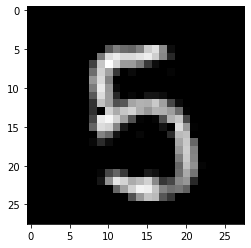

In [0]:
# Pick a few outputs and display them
import matplotlib.pyplot as plt
import random
import time


for _ in range(2):
    idx = random.randint(0, 20)
    out = outputs[idx, :].cpu().detach().numpy().reshape(28, 28) # Reshaping
    plt.imshow(out, cmap="gray")
    time.sleep(2)

